<a href="https://colab.research.google.com/github/tombackert/ml-stuff/blob/main/mnist_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import tensorflow as tf
import keras

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications import Xception  # For pre-trained model access (optional)
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras import backend as K  # For accessing layer outputs

# Display
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
import matplotlib as mpl


In [111]:
# model
def create_mnist_model():
  inputs = Input(shape=(28, 28, 1))
  x = Conv2D(32, (3, 3), activation='relu')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  outputs = Dense(10, activation='softmax')(x)
  model = Model(inputs=inputs, outputs=outputs)
  return model


In [112]:
# Load and Preprocess MNIST Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Reshape for compatibility with 2D convolutional layers
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)


In [113]:
# train the model
model = create_mnist_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/5
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1715 - accuracy: 0.9501 - val_loss: 0.0759 - val_accuracy: 0.9771
Epoch 2/5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0593 - accuracy: 0.9820 - val_loss: 0.0574 - val_accuracy: 0.9821
Epoch 3/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0410 - accuracy: 0.9872 - val_loss: 0.0517 - val_accuracy: 0.9848
Epoch 4/5
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0291 - accuracy: 0.9911 - val_loss: 0.0565 - val_accuracy: 0.9829
Epoch 5/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0213 - accuracy: 0.9934 - val_loss: 0.0560 - val_accuracy: 0.9835


In [114]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 5408)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                346176    
                                                                 
 dense_15 (Dense)            (None, 10)                650       
                                                           

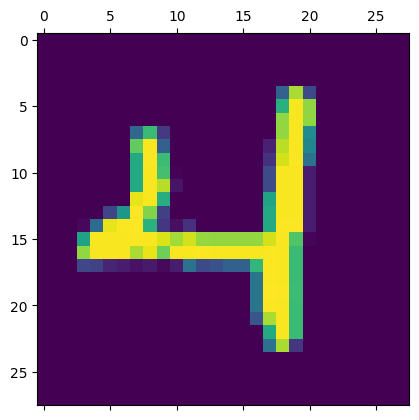

In [160]:
from PIL import Image
from IPython.display import display

test_image = x_test[103]
test_image_array = test_image
test_image = test_image.reshape(28, 28)
test_image = (test_image * 255).astype(np.uint8)

test_image = Image.fromarray(test_image, mode="L")
test_image.save('test_image.png')
img_path = 'test_image.png'

plt.matshow(test_image_array)
plt.show()

In [161]:
# parameters
img_size = (28, 28)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = 'conv2d_7'

img_path = img_path

In [165]:
# Grad-CAM algorithm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 28x28
    img = keras.utils.load_img(img_path, target_size=size, color_mode = "grayscale") # grayscale for shape (x, y, 1)
    # `array` is a float32 Numpy array of shape (299, 299, 1)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 [==============================] - 0s 23ms/step
Predicted: [[-113.84946     67.110275    -8.480155   -78.22684     69.039566
     3.0158675  -86.43222     20.753073  -106.41469    -38.91964  ]]


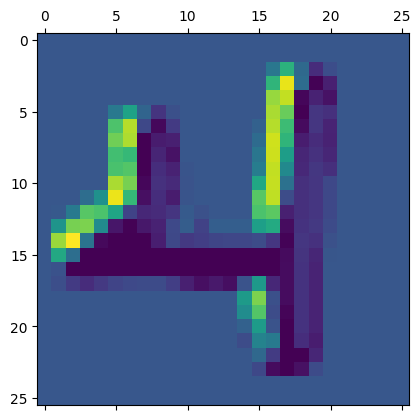

In [166]:
# test-drive

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size)) # we want

# Make model
model = model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


In [134]:
heatmap.shape

(26, 26)

<ipython-input-167-836eeed6ffda>:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(cmap=colormap), label="Relevance", boundaries=np.linspace(0, 1, 6))


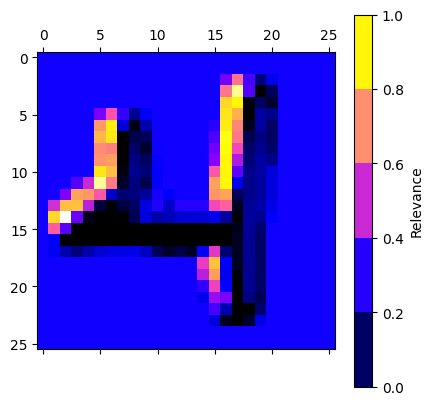

In [167]:
# create visualization
import matplotlib.colors as colors

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    colormap = mpl.colormaps["gnuplot2"]

    # Use RGB values of the colormap
    colormap_colors = colormap(np.arange(256))[:, :3]
    colormap_heatmap = colormap_colors[heatmap]

    plt.matshow(colormap_heatmap)
    # Add the legend using the chosen colormap
    plt.colorbar(mpl.cm.ScalarMappable(cmap=colormap), label="Relevance", boundaries=np.linspace(0, 1, 6))
    plt.show()

save_and_display_gradcam(img_path, heatmap)